### Исследовательский анализ данных

**Описание**: В компании заказов готовой еды генерится большой объем данных.

- Данные о заказах (когда, сколько, на какую сумму и куда была заказана еда)
- Информация о сессиях пользователей приложение и справочные данные о ресторанах и о курьерах.

**Задача**: Исследовать данные о клиентах и их покупках и предложить гипотезы для роста продаж.

План анализа данных:

- когортный анализ пользователей;
- исследование пользователей, кто не сделал заказ в определенное время;
- исследование частотности заказов и т.д.

В результате выполнения задачи мы ожидаем увидеть:

- дашборд;
- аналитику и гипотезы по увеличению продаж.

### Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
data = pd.read_csv('analytic-demo-data-master.csv')
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114401 entries, 0 to 114400
Data columns (total 20 columns):
id                        114401 non-null object
price                     114401 non-null float64
full_price                114401 non-null float64
final_price               114401 non-null float64
agent_amount              114401 non-null float64
agent_percent             114401 non-null float64
application_id            111101 non-null object
client_id                 114401 non-null object
created                   114401 non-null object
delivery_type             114401 non-null object
payment_type              114401 non-null object
is_service_delivery       114401 non-null bool
latitude                  112629 non-null float64
longitude                 112629 non-null float64
make_fast_as_possible     114401 non-null bool
date_of_finish_cooking    114401 non-null object
date_of_visit             114401 non-null object
place_id                  114319 non-null object
stat

In [3]:
data.describe()

price     full_price    final_price   agent_amount  \
count  114401.000000  114401.000000  114401.000000  114401.000000   
mean     1240.918106    1330.986033    1313.523591     267.641833   
std       953.548894     947.082479     951.273903     207.322601   
min         0.000000       0.000000       0.000000       0.000000   
25%       680.000000     790.000000     770.000000     150.000000   
50%      1050.000000    1130.000000    1115.000000     225.000000   
75%      1510.000000    1580.000000    1570.000000     333.000000   
max     32830.000000   32830.000000   32830.000000    6566.000000   

       agent_percent       latitude      longitude     user_count  
count  114401.000000  112629.000000  112629.000000  114401.000000  
mean       22.103076      45.045262      38.981595       1.364551  
std         7.519289       0.022572       0.036647       2.153561  
min         0.000000      44.953519      38.794940       0.000000  
25%        20.000000      45.028183      38.959074       1.000000  
50%        23.000000      45.042215      38.973166       1.000000  
75%        30.000000      45.060095      39.005326       1.000000  
max        32.000000      45.177498      39.202120     620.000000

In [15]:
#группировка заказов по статусу(завершение): общая сумма заказов и количество, а также количество уникальных клиентов по данному статусу.
info = data.groupby(['state']).agg({'final_price' : 'sum', 'id' : 'count', 'client_id' : 'nunique'})
info['final_price']=info['final_price'].round().astype(int)
info

final_price      id  client_id
state                                         
canceled              49036      92         39
canceled_bb         3842485    3428       2306
canceled_place      2408964    2062       1527
finished          143967928  108819      24789

Общая сумма завершенных заказов за исследуемый период составляет **108 819** c количеством уникальных клиентов **24 789**, на общую сумму **143 967 928** . 


In [10]:
print('Отмененные заказы', 114401 - 108819)
print('Отмененные заказы %', (114401 - 108819)/114401*100 )

Отмененные заказы 5582
Отмененные заказы % 4.879327977902291


Отменных заказов в общем количестве заявок **4,9%**, 5582 отмены

In [17]:
#группировка заказов по доставке
delivery =data.groupby(['is_service_delivery']).agg({'id' : 'count', 'client_id' : 'nunique'})
delivery

id  client_id
is_service_delivery                   
False                  4600       2627
True                 109801      24716

Для 4600 заявок доставки не было. 

In [18]:
#приводим даты к нужному типу
data['created'] = pd.to_datetime(data['created'],format='%Y-%m-%d')
data['date_of_finish_cooking'] = pd.to_datetime(data['date_of_finish_cooking'],format='%Y-%m-%d')
data['date_of_visit'] = pd.to_datetime(data['date_of_visit'],format='%Y-%m-%d')

### Когортный анализ пользователей

In [21]:
#Выборка заказов завершенных (исключаем все отмены)
df = data[ (data['state'] != 'canceled') & (data['state'] != 'canceled_bb') & (data['state'] != 'canceled_place')]

In [22]:
df.describe()

price     full_price    final_price   agent_amount  \
count  108819.000000  108819.000000  108819.000000  108819.000000   
mean     1251.068634    1340.605291    1323.003591     270.032020   
std       952.211201     946.096422     950.339039     207.826085   
min         0.000000       0.000000       0.000000       0.000000   
25%       690.000000     800.000000     780.000000     151.500000   
50%      1060.000000    1138.000000    1120.000000     226.750000   
75%      1520.000000    1590.000000    1576.000000     335.055000   
max     32830.000000   32830.000000   32830.000000    6566.000000   

       agent_percent       latitude      longitude     user_count  
count  108819.000000  107340.000000  107340.000000  108819.000000  
mean       22.141988      45.045270      38.981527       1.367197  
std         7.476223       0.022540       0.036615       2.188274  
min         0.000000      44.953519      38.809843       0.000000  
25%        20.000000      45.028139      38.959018       1.000000  
50%        23.000000      45.042394      38.973166       1.000000  
75%        30.000000      45.060096      39.005182       1.000000  
max        32.000000      45.177498      39.202120     620.000000

In [23]:
#для анализа возьмем только необходимые нам параметры (столбцы)
research = ['final_price', 'client_id', 'created', 'date_of_finish_cooking', 'date_of_visit']

In [24]:
# создаем рабочий dataframe под названием orders
orders= df[research]
# добавляем параметр когорты - месяц первого заказа в формате "год-месяц"
orders['cohort'] = orders.date_of_finish_cooking.apply(lambda x: x.strftime('%Y-%m'))

#добавим индекс в dataFrame по ClientID для группировки
orders.set_index('client_id', inplace=True)
#добавим дату (месяц) самого первого заказа 
orders['first_month'] = orders.groupby(level=0)['date_of_finish_cooking'].min().apply(lambda x: x.strftime('%Y-%m'))
#переиндексируем снова
orders.reset_index(inplace=True) 
#создадим столбец в котором далее поместим количество заказов
orders.insert(len(orders.columns), "total_orders", 0, allow_duplicates=False)

orders.head()

/Users/kate/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/kate/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


client_id  final_price  \
0  bad3d57d-4760-43e3-891f-c6f6fb123499       1749.0   
1  f2eaebdf-7878-463a-91b9-20616fdcd4cf        560.0   
2  f6ef3117-23fb-4a89-93d6-6a13092c27f6       1000.0   
3  bd8a7330-289c-4fc1-b8f9-0f4700bdc26d       2860.0   
4  e73e2099-ae9a-43f4-9c7c-31e005d59ad5        750.0   

                           created    date_of_finish_cooking  \
0 2019-05-29 12:43:51.299000+03:00 2019-05-29 13:08:00+03:00   
1 2019-06-17 20:18:55.371000+03:00 2019-06-17 20:43:00+03:00   
2 2019-06-10 18:09:35.273000+03:00 2019-06-10 18:34:00+03:00   
3 2019-06-10 17:38:28.019000+03:00 2019-06-10 18:03:00+03:00   
4 2019-06-17 20:23:18.112000+03:00 2019-06-17 20:40:00+03:00   

              date_of_visit   cohort first_month  total_orders  
0 2019-05-29 14:00:00+03:00  2019-05     2019-05             0  
1 2019-06-17 21:05:00+03:00  2019-06     2019-06             0  
2 2019-06-10 19:00:00+03:00  2019-06     2019-05             0  
3 2019-06-10 18:30:00+03:00  2019-06     2018-09             0  
4 2019-06-17 21:20:00+03:00  2019-06     2019-01             0

In [25]:
#сгруппируем данные в когорты
grouped = orders.groupby(['first_month', 'cohort'])

# количество уникальных пользователей и общее количество заказов и выручка за период
cohorts = grouped.agg({'client_id': pd.Series.nunique,
                       'total_orders': pd.Series.count, 
                       'final_price': np.sum})

# переименуем некоторые столбцы 
cohorts.rename(columns={'client_id': 'total_users',
                        'total_orders': 'total_orders'}, inplace=True)


In [26]:
# добавим номер для периодов
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1 # отсчет с 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts


total_users  total_orders  final_price  cohort_period
first_month cohort                                                        
2017-08     2017-08            3            10      9975.00              1
            2017-09            1            27     20190.00              2
            2017-10            2            22     26095.00              3
            2017-11            1            12     26845.00              4
            2017-12            2            64     68055.00              5
...                          ...           ...          ...            ...
2019-05     2019-06          252           564    729901.15              2
            2019-07          178           382    565580.15              3
2019-06     2019-06         1480          1807   2115594.45              1
            2019-07          223           454    581624.55              2
2019-07     2019-07         1272          1616   2031043.90              1

[296 rows x 4 columns]

In [27]:
#проверочный код
x = orders[(orders.first_month == '2017-08') & (orders.cohort == '2017-08')]
y = cohorts.loc[('2017-08', '2017-08')]
assert(x['client_id'].nunique() == y['total_users'])
assert(x['final_price'].sum() == y['final_price'])

In [28]:
#посчитаем retention

# переиндексируем dataframe cohorts
cohorts.reset_index(inplace=True)
cohorts.set_index(['first_month','cohort_period'], inplace=True)

# создадим ряд содержаший размер каждой когорты first_month
cohort_group_size = cohorts['total_users'].groupby(level=0).first()
cohorts['total_users'].unstack(0)


first_month    2017-08  2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  \
cohort_period                                                                  
1                  3.0     10.0     14.0     25.0     56.0    122.0    234.0   
2                  1.0      2.0      6.0      3.0     26.0     43.0     86.0   
3                  2.0      1.0      7.0      2.0     23.0     37.0     75.0   
4                  1.0      2.0      5.0      3.0     30.0     38.0     70.0   
5                  2.0      1.0      5.0      2.0     21.0     41.0     71.0   
6                  2.0      1.0      4.0      2.0     21.0     37.0     71.0   
7                  1.0      2.0      3.0      1.0     29.0     34.0     73.0   
8                  2.0      1.0      3.0      1.0     19.0     33.0     77.0   
9                  2.0      1.0      5.0      2.0     22.0     31.0     77.0   
10                 2.0      1.0      5.0      1.0     17.0     33.0     76.0   
11                 1.0      1.0      3.0      2.0     22.0     35.0     80.0   
12                 2.0      2.0      3.0      1.0     23.0     40.0     82.0   
13                 2.0      1.0      4.0      1.0     27.0     29.0     83.0   
14                 2.0      1.0      3.0      2.0     24.0     31.0     69.0   
15                 1.0      1.0      1.0      1.0     22.0     29.0     76.0   
16                 1.0      1.0      2.0      2.0     24.0     28.0     77.0   
17                 1.0      1.0      2.0      2.0     22.0     34.0     71.0   
18                 1.0      1.0      1.0      1.0     18.0     34.0     57.0   
19                 2.0      1.0      1.0      2.0     15.0     32.0      NaN   
20                 2.0      NaN      1.0      2.0     23.0      NaN      NaN   
21                 1.0      NaN      2.0      2.0      NaN      NaN      NaN   
22                 1.0      NaN      2.0      NaN      NaN      NaN      NaN   
23                 1.0      NaN      NaN      NaN      NaN      NaN      NaN   
24                 1.0      NaN      NaN      NaN      NaN      NaN      NaN   

first_month    2018-03  2018-04  2018-05  ...  2018-10  2018-11  2018-12  \
cohort_period                             ...                              
1                363.0    571.0    675.0  ...   1831.0   2465.0   2446.0   
2                136.0    185.0    228.0  ...    485.0    603.0    526.0   
3                123.0    171.0    208.0  ...    435.0    443.0    281.0   
4                114.0    164.0    191.0  ...    339.0    289.0    256.0   
5                123.0    154.0    200.0  ...    282.0    282.0    209.0   
6                114.0    142.0    199.0  ...    266.0    245.0    223.0   
7                111.0    138.0    193.0  ...    240.0    245.0    197.0   
8                112.0    142.0    186.0  ...    243.0    239.0    174.0   
9                106.0    149.0    162.0  ...    224.0    198.0      NaN   
10               106.0    158.0    163.0  ...    204.0      NaN      NaN   
11               103.0    160.0    169.0  ...      NaN      NaN      NaN   
12               107.0    138.0    168.0  ...      NaN      NaN      NaN   
13               107.0    135.0    151.0  ...      NaN      NaN      NaN   
14               103.0    127.0    154.0  ...      NaN      NaN      NaN   
15               108.0    121.0    143.0  ...      NaN      NaN      NaN   
16               120.0    111.0      NaN  ...      NaN      NaN      NaN   
17                96.0      NaN      NaN  ...      NaN      NaN      NaN   
18                 NaN      NaN      NaN  ...      NaN      NaN      NaN   
19                 NaN      NaN      NaN  ...      NaN      NaN      NaN   
20                 NaN      NaN      NaN  ...      NaN      NaN      NaN   
21                 NaN      NaN      NaN  ...      NaN      NaN      NaN   
22                 NaN      NaN      NaN  ...      NaN      NaN      NaN   
23                 NaN      NaN      NaN  ...      NaN      NaN      NaN   
24                 

In [29]:
cohorts['total_users'].astype(int)
user_retention = cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention

first_month     2017-08  2017-09   2017-10  2017-11   2017-12   2018-01  \
cohort_period                                                             
1              1.000000      1.0  1.000000     1.00  1.000000  1.000000   
2              0.333333      0.2  0.428571     0.12  0.464286  0.352459   
3              0.666667      0.1  0.500000     0.08  0.410714  0.303279   
4              0.333333      0.2  0.357143     0.12  0.535714  0.311475   
5              0.666667      0.1  0.357143     0.08  0.375000  0.336066   
6              0.666667      0.1  0.285714     0.08  0.375000  0.303279   
7              0.333333      0.2  0.214286     0.04  0.517857  0.278689   
8              0.666667      0.1  0.214286     0.04  0.339286  0.270492   
9              0.666667      0.1  0.357143     0.08  0.392857  0.254098   
10             0.666667      0.1  0.357143     0.04  0.303571  0.270492   
11             0.333333      0.1  0.214286     0.08  0.392857  0.286885   
12             0.666667      0.2  0.214286     0.04  0.410714  0.327869   
13             0.666667      0.1  0.285714     0.04  0.482143  0.237705   
14             0.666667      0.1  0.214286     0.08  0.428571  0.254098   
15             0.333333      0.1  0.071429     0.04  0.392857  0.237705   
16             0.333333      0.1  0.142857     0.08  0.428571  0.229508   
17             0.333333      0.1  0.142857     0.08  0.392857  0.278689   
18             0.333333      0.1  0.071429     0.04  0.321429  0.278689   
19             0.666667      0.1  0.071429     0.08  0.267857  0.262295   
20             0.666667      NaN  0.071429     0.08  0.410714       NaN   
21             0.333333      NaN  0.142857     0.08       NaN       NaN   
22             0.333333      NaN  0.142857      NaN       NaN       NaN   
23             0.333333      NaN       NaN      NaN       NaN       NaN   
24             0.333333      NaN       NaN      NaN       NaN       NaN   

first_month     2018-02   2018-03   2018-04   2018-05  ...   2018-10  \
cohort_period                                          ...             
1              1.000000  1.000000  1.000000  1.000000  ...  1.000000   
2              0.367521  0.374656  0.323993  0.337778  ...  0.264883   
3              0.320513  0.338843  0.299475  0.308148  ...  0.237575   
4              0.299145  0.314050  0.287215  0.282963  ...  0.185145   
5              0.303419  0.338843  0.269702  0.296296  ...  0.154014   
6              0.303419  0.314050  0.248687  0.294815  ...  0.145276   
7              0.311966  0.305785  0.241681  0.285926  ...  0.131076   
8              0.329060  0.308540  0.248687  0.275556  ...  0.132714   
9              0.329060  0.292011  0.260946  0.240000  ...  0.122338   
10             0.324786  0.292011  0.276708  0.241481  ...  0.111415   
11             0.341880  0.283747  0.280210  0.250370  ...       NaN   
12             0.350427  0.294766  0.241681  0.248889  ...       NaN   
13             0.354701  0.294766  0.236427  0.223704  ...       NaN   
14             0.294872  0.283747  0.222417  0.228148  ...       NaN   
15             0.324786  0.297521  0.211909  0.211852  ...       NaN   
16             0.329060  0.330579  0.194396       NaN  ...       NaN   
17             0.303419  0.264463       NaN       NaN  ...       NaN   
18             0.243590       NaN       NaN       NaN  ...       NaN   
19                  NaN       NaN       NaN       NaN  ...       NaN   
20                  NaN       NaN       NaN       NaN  ...       NaN   
21                  NaN       NaN       NaN       NaN  ...       NaN   
22                  NaN       NaN       NaN       NaN  ...       NaN   
23                  NaN       NaN       NaN       NaN  ...       NaN   
24                  NaN       NaN       NaN       NaN  ...       NaN   

first_month     2018-11   2018-12   2019-01   2019-02   2019-03   2019-04  \
cohort_period                                                               
1              1.00000

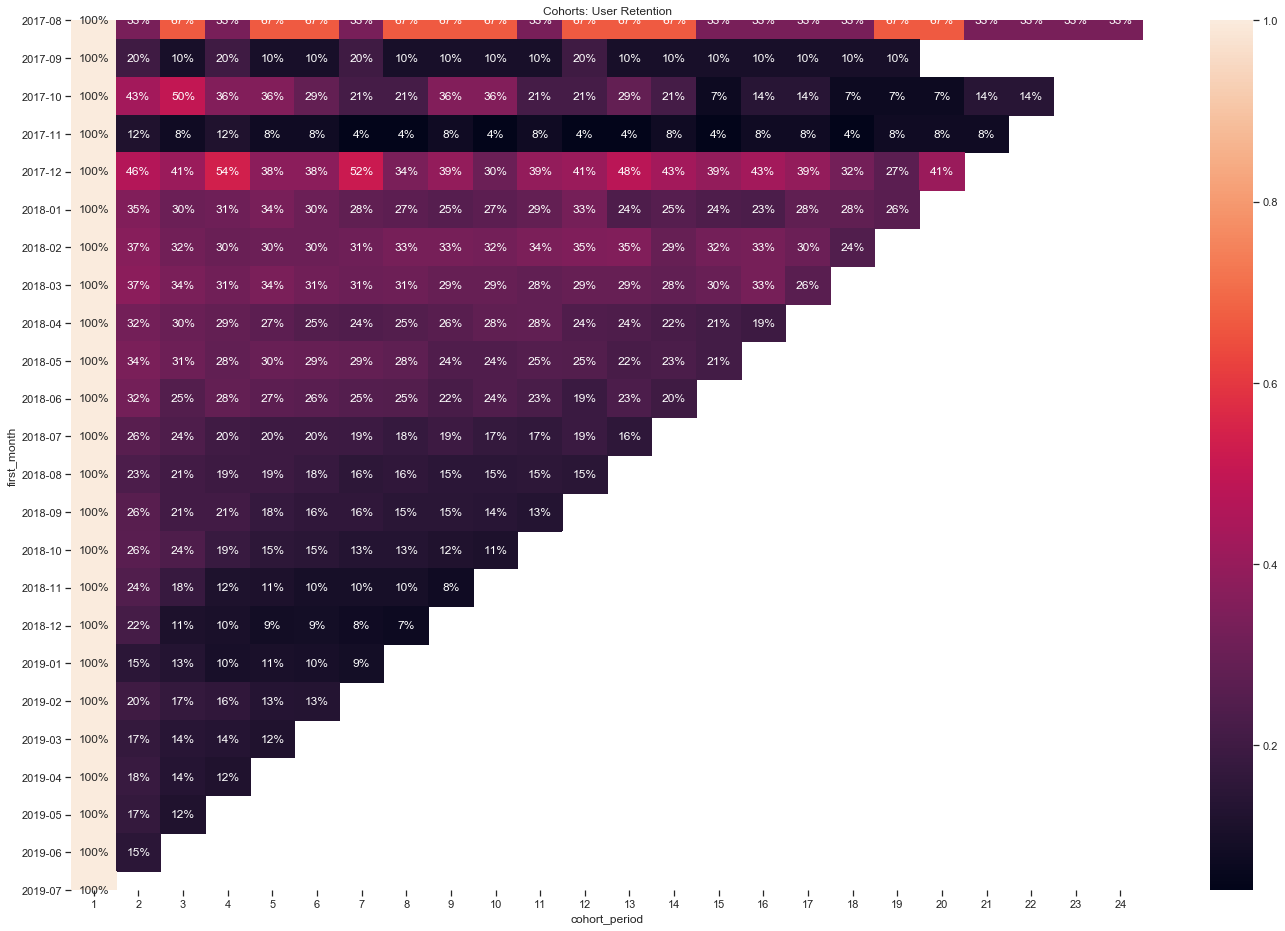

In [30]:
import seaborn as sns
sns.set(style='ticks')
plt.figure(figsize=(24, 16))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.00%')


**Вывод**: По полученной тепловой карте и ее значениям retention  мы наблюдаем, что когорты более ранних периодов (первых заказов) имеют более высокий процент удержания клиентов, выше 30%. 

Диагонаьная линия карты когорт показывает, что на момент загрузки данных (июль 2019) только клиенты первой когорты (авг 2017) стабильно возвращались и совершали покупки в течение 24 месяцев с момента первой транзакции. 

Такая логика распространяется и на другие когорты, но есть исключения. 
Обратите внимание, что в когорте в ноября 2017г. наблюдается сравнительно низкие показатели удержания. Возможно в этот месяц были сбои в работе сервиса.

Также мы можем сравнить показатели удержания на 2 когортный период (месяц) между когортами клиентов, и очевидно снижение с 30-45% (в 2017) до 15-17% (в 2019) возвращаемости клиентов к сервису. 

Эта отрицательная тенденция может говорить о разных причинах:
- 1 Гипотеза: Снижение эффективности маркетинговых кампаний и каналов продаж
- 2 Гипотеза: Повышение цен
- 3 Гипотеза: Продуктовое предложение, ушли к конкурентам. 
- 4 Гипотеза: Снижение эффективности работы службы поддержки клиентов

**Решения**:
 1) Персонализаированные письма, скидки, купоны
 2) Программа скидок на повторную покупку

Создание постоянных клиентов гораздо выгоднее, чем привлечение новых клиентов.


### Исследование пользователей, кто не сделал заказ 

In [72]:
print('Отмененные заказы', 114401 - 108819)
print('Отмененные заказы %', (114401 - 108819)/114401*100 )

Отмененные заказы 5582
Отмененные заказы % 4.879327977902291


Как уже известно, что отменных заказов в общем количестве заявок 4,9%, 5582 отмены. Рассмотрим данные более детально.

In [79]:
# сформируем выборку по отказам 'canceled'
cancel = data[(data['state'] == 'canceled')+(data['state'] == 'canceled_bb')+(data['state'] == 'canceled_place')]
cancel['diff'] =  data['date_of_finish_cooking'] - data['created']
cancel.describe()

/Users/kate/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


price    full_price   final_price  agent_amount  agent_percent  \
count   5582.000000   5582.000000   5582.000000   5582.000000    5582.000000   
mean    1043.037352   1143.462200   1128.714556    221.046041      21.344500   
std      958.098199    946.862545    950.701765    191.394733       8.278681   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%      514.000000    605.000000    597.000000     97.500000      15.000000   
50%      879.500000   1000.000000   1000.000000    183.000000      20.000000   
75%     1300.000000   1405.000000   1400.000000    297.725000      30.000000   
max    20096.000000  20096.000000  20096.000000   2934.000000      32.000000   

          latitude    longitude   user_count                      diff  
count  5289.000000  5289.000000  5582.000000                      5582  
mean     45.045104    38.982974     1.312970    0 days 01:54:55.729947  
std       0.023215     0.037251     1.302778    0 days 04:23:40.524693  
min      44.973258    38.794940     0.000000  -1 days +00:01:31.494000  
25%      45.030107    38.960841     1.000000    0 days 00:23:48.529750  
50%      45.039744    38.973166     1.000000    0 days 00:24:58.903000  
75%      45.058944    39.007122     1.000000    0 days 00:39:54.046750  
max      45.155154    39.139166    50.000000    1 days 03:37:39.742000

In [80]:
#общая сумма отмененных заказов и количество, а также количество уникальных клиентов, отменивших заказ.
cancel_info = cancel.groupby(['state']).agg({'final_price' : 'sum', 'id' : 'count', 'client_id' : 'nunique'})
cancel_info

final_price    id  client_id
state                                       
canceled           49035.50    92         39
canceled_bb      3842484.70  3428       2306
canceled_place   2408964.45  2062       1527

In [81]:
order_over_1hour = cancel.loc[cancel['diff'] > '0 days 01:00:00.858750']
order_over_1hour.groupby(['state']).\
agg({'final_price' : 'sum', 'id' : 'count', 'client_id' : 'nunique'})

final_price   id  client_id
state                                      
canceled             9681.0   15          6
canceled_bb        920368.8  786        584
canceled_place     354376.7  284        247

**Вывод:** 

15 **canceled** отмены из 92, что составляет **16,3 %**  - были больше 1 часа.

785 **canceled_bb** отмены из 3428, что составляет **22,9 %** - были больше 1 часа.

282 **canceled_place** отмены из 2062, что составляет **13.67 %** - были больше 1 часа.


Такая статистика говорит о том, что в основном более 77% отменяемых заказов были отменены в течение часа. В данном случае нужно проводить дополнительный анализ по причинам отказа. Остальные % отказов возможно были отменены по причине долгого приготовления/доставки.


Количество уникальных пользователей в каждой из групп значительно меньше заказов, что значит, что данные пользователи отказывались более 1 раза.

In [84]:
#группировка заказов по статусу(завершение):  даты
info = data.groupby(['state']).agg({'created' : 'count', 'date_of_finish_cooking' : 'count', 'date_of_visit' : 'count'})

info

created  date_of_finish_cooking  date_of_visit
state                                                         
canceled             92                      92             92
canceled_bb        3428                    3428           3428
canceled_place     2062                    2062           2062
finished         108819                  108819         108819

### Исследование частотности заказов

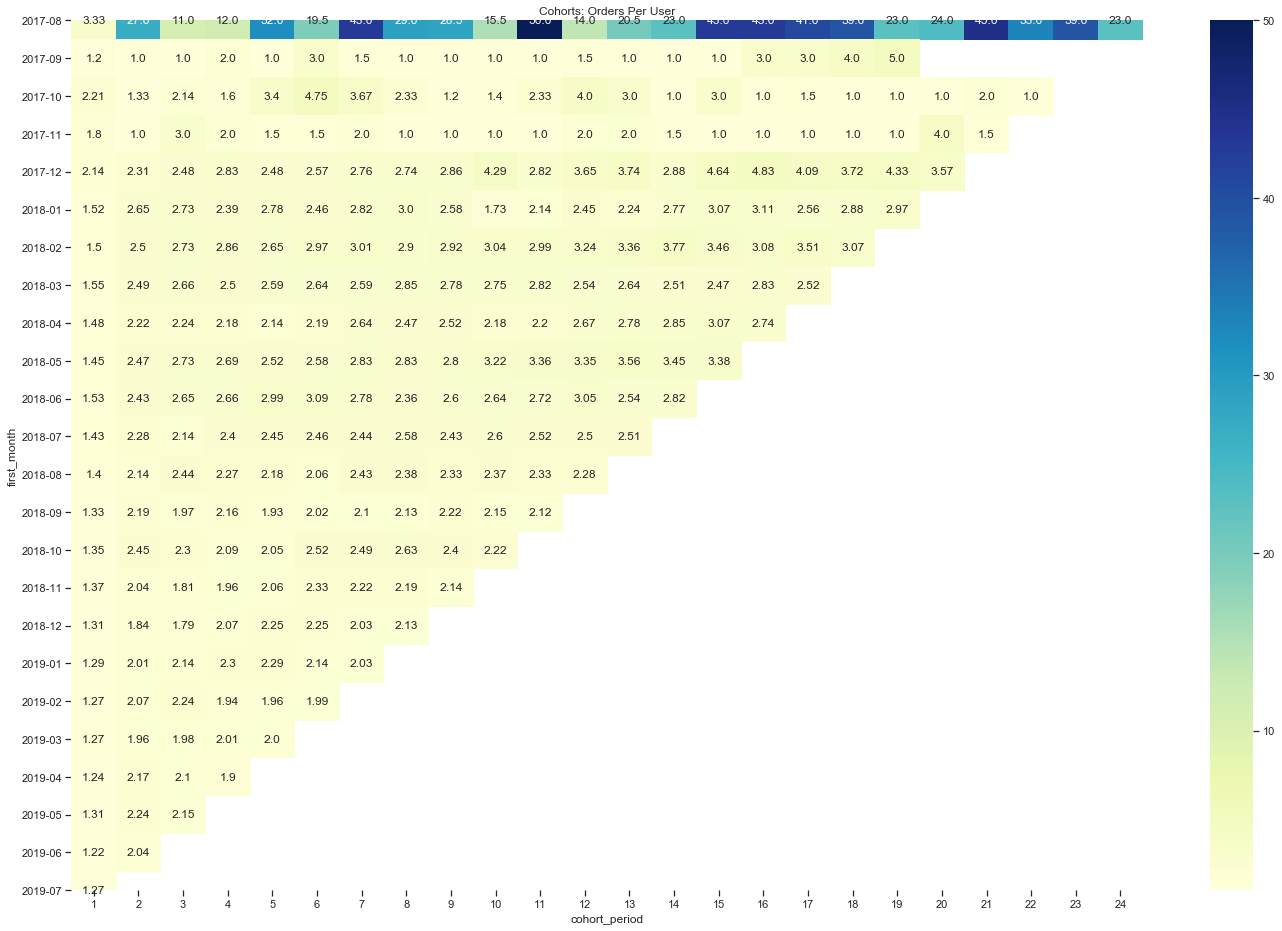

In [82]:
## Расчитаем частоту заказов по когортам
c = cohorts['total_orders']/cohorts['total_users']
opc = c.unstack(0)

sns.set(style='ticks')
plt.figure(figsize=(24, 16))
plt.title('Cohorts: Orders Per User')
sns.heatmap(opc.T, cmap="YlGnBu", mask=opc.T.isnull(), annot=True, fmt='.3')

**Вывод**: За исключением 1й первой когороты, в других группах пользователей во все периоды покупают примерно одинаково, в среднем - 2,5 раза за период.